
# Arguments

In [1]:
num_of_epochs = 25
batch_size = 32

model_save_path = 'model-warmedup.h5'

dataset_name = 'tomato-dataset'
dataset_path = '../datasets/' + dataset_name

checkpoint_path = 'warmup-checkpoints.hdf5'

input_width = 224
input_height = 224
input_depth = 3

# Get classes
import os
import re
classes = os.listdir(dataset_path)
class_names = []

for i in classes:
    if(re.search("Tomato___", i)):
        class_names.append(i)
    
print('Classes: ', class_names)
print(len(class_names))

Classes:  ['Tomato___Tomato_mosaic_virus', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Bacterial_spot', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___healthy', 'Tomato___Septoria_leaf_spot', 'Tomato___Two-spotted_spider_mite']
10


# Load original ResNet model

In [2]:
from keras.applications import ResNet50
from keras.utils.vis_utils import plot_model
from keras.layers import Input

base_model = ResNet50(weights=None)

plot_save_path = 'diagram-resnet-full.png'
# plot_model(base_model, to_file=plot_save_path, show_shapes=True)

# iterate for all layers in the network and print its' index value
for (i,layer) in enumerate(base_model.layers):
    print("[INFO] {}\t{}".format(i,layer.__class__.__name__))

Using TensorFlow backend.


[INFO] 0	InputLayer
[INFO] 1	ZeroPadding2D
[INFO] 2	Conv2D
[INFO] 3	BatchNormalization
[INFO] 4	Activation
[INFO] 5	ZeroPadding2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	BatchNormalization
[INFO] 9	Activation
[INFO] 10	Conv2D
[INFO] 11	BatchNormalization
[INFO] 12	Activation
[INFO] 13	Conv2D
[INFO] 14	Conv2D
[INFO] 15	BatchNormalization
[INFO] 16	BatchNormalization
[INFO] 17	Add
[INFO] 18	Activation
[INFO] 19	Conv2D
[INFO] 20	BatchNormalization
[INFO] 21	Activation
[INFO] 22	Conv2D
[INFO] 23	BatchNormalization
[INFO] 24	Activation
[INFO] 25	Conv2D
[INFO] 26	BatchNormalization
[INFO] 27	Add
[INFO] 28	Activation
[INFO] 29	Conv2D
[INFO] 30	BatchNormalization
[INFO] 31	Activation
[INFO] 32	Conv2D
[INFO] 33	BatchNormalization
[INFO] 34	Activation
[INFO] 35	Conv2D
[INFO] 36	BatchNormalization
[INFO] 37	Add
[INFO] 38	Activation
[INFO] 39	Conv2D
[INFO] 40	BatchNormalization
[INFO] 41	Activation
[INFO] 42	Conv2D
[INFO] 43	BatchNormalization
[INFO] 44	Activation
[INFO] 45	Conv2D
[INFO] 46


# Load model

In [3]:
from keras.applications import ResNet50
from keras.utils.vis_utils import plot_model
from keras.layers import Input



# Load pretrianed VGG model with FC layers removed
# explicitly deﬁne the input_tensor to be 224×224×3 pixels
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_tensor=Input(shape = (input_width,input_height, input_depth)))

plot_save_path = 'resnet-base-model.png'
# plot_model(base_model, to_file=plot_save_path, show_shapes=True)

# iterate for all layers in the network and print its' index value
for (i,layer) in enumerate(base_model.layers):
    print("[INFO] {}\t{}".format(i,layer.__class__.__name__))

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


[INFO] 0	InputLayer
[INFO] 1	ZeroPadding2D
[INFO] 2	Conv2D
[INFO] 3	BatchNormalization
[INFO] 4	Activation
[INFO] 5	ZeroPadding2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	BatchNormalization
[INFO] 9	Activation
[INFO] 10	Conv2D
[INFO] 11	BatchNormalization
[INFO] 12	Activation
[INFO] 13	Conv2D
[INFO] 14	Conv2D
[INFO] 15	BatchNormalization
[INFO] 16	BatchNormalization
[INFO] 17	Add
[INFO] 18	Activation
[INFO] 19	Conv2D
[INFO] 20	BatchNormalization
[INFO] 21	Activation
[INFO] 22	Conv2D
[INFO] 23	BatchNormalization
[INFO] 24	Activation
[INFO] 25	Conv2D
[INFO] 26	BatchNormalization
[INFO] 27	Add
[INFO] 28	Activation
[INFO] 29	Conv2D
[INFO] 30	BatchNormalization
[INFO] 31	Activation
[INFO] 32	Conv2D
[INFO] 33	BatchNormalization
[INFO] 34	Activation
[INFO] 35	Conv2D
[INFO] 36	BatchNormalization
[INFO] 37	Add
[INFO] 38	Activation
[INFO] 39	Conv2D
[INFO] 40	BatchNormalization
[INFO] 41	Activation
[INFO] 42	Conv2D
[INFO] 43	BatchNormalization
[INFO] 44	Activation
[INFO] 45	Conv2D
[INFO] 46

# Custom FC layer

In [4]:
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense

head_model = base_model.output
head_model = Flatten(name='flatten')(head_model)
head_model = Dense(256,activation='relu')(head_model)
head_model = Dropout(0.5)(head_model)
# Add a softmaxc layer
head_model = Dense(len(class_names),activation='softmax')(head_model)

# plot_save_path = 'custom-head.png'
# plot_model(head_model, to_file=model_diagram_path, show_shapes=True)

# Attach custom head to model

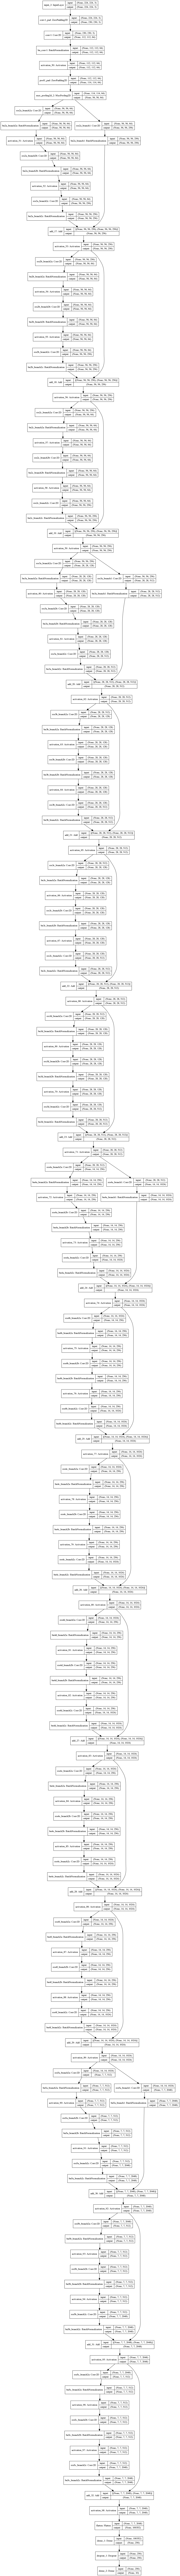

In [5]:
from keras.models import Model


# place the head FC model on top of the base model 
model = Model(inputs=base_model.input, outputs = head_model)

# freeze weights in base model
for layer in base_model.layers:
    layer.trainable = False

plot_save_path = 'diagram-custom-head-attached.png'
plot_model(model, to_file=plot_save_path, show_shapes=True)

# Freeze base model

In [6]:
# traverse all layers and freeze the weight of the corresponding layer
for layer in base_model.layers:
    layer.trainable = False

# Compile model

In [7]:
from keras.optimizers import RMSprop

print("[INFO] compiling model...")
opt = RMSprop(lr=0.001)

model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
# Since we only train the new fully connected layer, we do a few iterations
print("[INFO] training head...")

[INFO] compiling model...
[INFO] training head...


# Load data

In [8]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image   import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.layers import Input
from keras.models import Model
from keras .applications import VGG16
from keras.optimizers import SGD
from keras.models import Model
from imutils import paths
import numpy as np
import os

import sys
sys.path.append('..')

from utils.preprocessors.aspect_aware_preprocessor import AspectAwarePreprocessor
from utils.preprocessors.image_to_array_preprocessor import ImageToArrayPreprocessor
from utils.io.simple_dataset_loader import SimpleDatasetLoader

# construct the image generator for data augmentation
aug = ImageDataGenerator(   rotation_range=30,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

# Load image paths
print("[INFO] loading images...")
image_paths = list(paths.list_images(dataset_path))

# Initial image preprocessing
aap = AspectAwarePreprocessor(input_width, input_height)
iap= ImageToArrayPreprocessor()

#Load image data and perform image data preprocessing
sdl = SimpleDatasetLoader(preprocessors=[aap,iap])
(data,labels)  = sdl.load(image_paths,verbose=500)
data = data.astype("float") / 255.0


# train test split
(train_x,test_x,train_y,test_y) = train_test_split(data,labels,test_size=0.25,random_state=42)

# convert the labels from integers to vectors
train_y = LabelBinarizer().fit_transform(train_y)
test_y = LabelBinarizer().fit_transform(test_y)



[INFO] loading images...
[INFO]: Processed 500/18160
[INFO]: Processed 1000/18160
[INFO]: Processed 1500/18160
[INFO]: Processed 2000/18160
[INFO]: Processed 2500/18160
[INFO]: Processed 3000/18160
[INFO]: Processed 3500/18160
[INFO]: Processed 4000/18160
[INFO]: Processed 4500/18160
[INFO]: Processed 5000/18160
[INFO]: Processed 5500/18160
[INFO]: Processed 6000/18160
[INFO]: Processed 6500/18160
[INFO]: Processed 7000/18160
[INFO]: Processed 7500/18160
[INFO]: Processed 8000/18160
[INFO]: Processed 8500/18160
[INFO]: Processed 9000/18160
[INFO]: Processed 9500/18160
[INFO]: Processed 10000/18160
[INFO]: Processed 10500/18160
[INFO]: Processed 11000/18160
[INFO]: Processed 11500/18160
[INFO]: Processed 12000/18160
[INFO]: Processed 12500/18160
[INFO]: Processed 13000/18160
[INFO]: Processed 13500/18160
[INFO]: Processed 14000/18160
[INFO]: Processed 14500/18160
[INFO]: Processed 15000/18160
[INFO]: Processed 15500/18160
[INFO]: Processed 16000/18160
[INFO]: Processed 16500/18160
[INFO

# Checkpoints

In [9]:
from keras.callbacks import ModelCheckpoint


checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', 
save_best_only=True, verbose=1)

callbacks = [checkpoint]



In [10]:
#load checkpoints if existing

import os

epochs_done = 1

if(os.path.exists(checkpoint_path)):
    model.load_weights(checkpoint_path)
    num_of_epochs = num_of_epochs - epochs_done


# Warm up head

In [11]:


H = model.fit_generator(
                        aug.flow(train_x,train_y, batch_size = 32),
                                 validation_data = (test_x,test_y),
                                 epochs=num_of_epochs,
                                 steps_per_epoch = len(train_x) //32,
                                 verbose = 1,
                                 callbacks=callbacks)

model.save(model_save_path)

Epoch 1/25
425/425 [==============================] - 226s 532ms/step - loss: 2.8901 - accuracy: 0.5514 - val_loss: 8.8879 - val_accuracy: 0.1035

Epoch 00001: val_loss improved from inf to 8.88787, saving model to warmup-checkpoints.hdf5
Epoch 2/25
425/425 [==============================] - 223s 525ms/step - loss: 1.2086 - accuracy: 0.6867 - val_loss: 9.3823 - val_accuracy: 0.1035

Epoch 00002: val_loss did not improve from 8.88787
Epoch 3/25
425/425 [==============================] - 222s 522ms/step - loss: 1.0488 - accuracy: 0.7317 - val_loss: 13.7464 - val_accuracy: 0.1035

Epoch 00003: val_loss did not improve from 8.88787
Epoch 4/25
425/425 [==============================] - 224s 528ms/step - loss: 1.0229 - accuracy: 0.7544 - val_loss: 21.4948 - val_accuracy: 0.1035

Epoch 00004: val_loss did not improve from 8.88787
Epoch 5/25
425/425 [==============================] - 223s 525ms/step - loss: 0.9548 - accuracy: 0.7724 - val_loss: 27.8276 - val_accuracy: 0.1035

Epoch 00005: val_

# Visualize

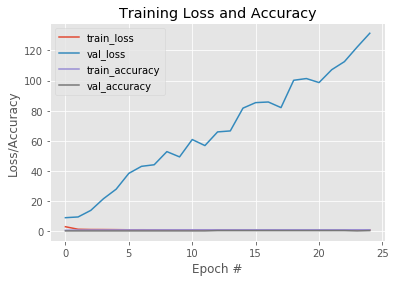

In [12]:
plot_save_path = 'plot.png'

# plot the training loss and accuracy
from matplotlib import pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_of_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_of_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_of_epochs), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, num_of_epochs), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
#save to disk
plt.savefig(plot_save_path)
plt.show()

# Evaluate after warmup

In [13]:
from sklearn.metrics import classification_report

print("[INFO] evaluating after initialization...")
predictions = model.predict(test_x,batch_size=32)
print(classification_report(test_y.argmax(axis =1),
                            predictions.argmax(axis =1),target_names=class_names))

[INFO] evaluating after initialization...
                                        precision    recall  f1-score   support

          Tomato___Tomato_mosaic_virus       0.00      0.00      0.00       532
                 Tomato___Early_blight       0.00      0.00      0.00       239
                  Tomato___Late_blight       0.00      0.00      0.00       470
                    Tomato___Leaf_Mold       0.00      0.00      0.00       238
               Tomato___Bacterial_spot       0.00      0.00      0.00       435
                  Tomato___Target_Spot       0.00      0.00      0.00       362
Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.30      1.00      0.46      1355
                      Tomato___healthy       0.00      0.00      0.00        98
           Tomato___Septoria_leaf_spot       0.00      0.00      0.00       414
      Tomato___Two-spotted_spider_mite       0.00      0.00      0.00       397

                           avg / total       0.09      0.30      0.14      4

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
